In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
import sklearn
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras import optimizers
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import precision_recall_fscore_support as score
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.utils.multiclass import unique_labels

## Read csv file of features (extracted from temperature)
## Load features from csv files
labeled_temp_feat = pd.read_csv('labeled_temp_feat.csv')
labeled_temp_feat['date'] = pd.to_datetime(labeled_temp_feat['date'], format="%Y-%m-%d %H:%M:%S")

# Set index as date
# df_Temp = df_Temp.set_index('date')

# print ("type(df_Temp['date'])", type(df_Temp['date']).__name__)
# print ("type(df_Temp['date'][0])", type(df_Temp['date'][0]).__name__)

#add cycle column to compute RUL and cycle based classification
cycle_array = np.arange(len(labeled_temp_feat))+1
print (labeled_temp_feat)

labeled_temp_feat['cycle'] = cycle_array

labeled_temp_feat


Using TensorFlow backend.


The nltk version is 3.4.5.
The scikit-learn version is 0.21.3.
                      date  max_temp_10_min  min_temp_10_min  \
0      2018-01-31 00:10:00        20.742374        18.432066   
1      2018-01-31 00:20:00        20.721078        18.640298   
2      2018-01-31 00:30:00        20.326355        18.887713   
3      2018-01-31 00:40:00        23.860218        19.153188   
4      2018-01-31 00:50:00        22.802077        18.699538   
...                    ...              ...              ...   
113751 2020-03-30 22:40:00        20.526754        19.041705   
113752 2020-03-30 22:50:00        21.184445        19.619322   
113753 2020-03-30 23:00:00        21.053281        18.571510   
113754 2020-03-30 23:10:00        20.381125        19.495779   
113755 2020-03-30 23:20:00        20.205893        18.717884   

        mean_temp_10_min  std_temp_10_min  var_temp_10_min  \
0              19.732618         0.705365         0.497540   
1              19.769415         0.637207   

,date,max_temp_10_min,min_temp_10_min,mean_temp_10_min,std_temp_10_min,var_temp_10_min,median_temp_10_min,max_temp_30_min,min_temp_30_min,mean_temp_30_min,...,max_temp_60_min,min_temp_60_min,mean_temp_60_min,std_temp_60_min,var_temp_60_min,median_temp_60_min,skew_temp_60_min,kurt_temp_60_min,label,cycle
0,2018-01-31 00:10:00,20.742374,18.432066,19.732618,0.705365,0.497540,19.822494,20.742374,18.432066,19.691256,...,23.860218,18.432066,20.483673,1.368903,1.873896,20.095683,0.902775,-0.104870,abnormal(hot),1
1,2018-01-31 00:20:00,20.721078,18.640298,19.769415,0.637207,0.406033,19.677249,20.742374,18.432066,19.675702,...,23.860218,18.432066,20.502969,1.364673,1.862333,20.164130,0.871933,-0.123906,abnormal(hot),2
2,2018-01-31 00:30:00,20.326355,18.887713,19.571735,0.487229,0.237392,19.576891,23.860218,18.640298,20.637840,...,23.860218,18.640298,20.558204,1.324254,1.753649,20.219096,0.916044,-0.057574,abnormal(hot),3
3,2018-01-31 00:40:00,23.860218,19.153188,22.272325,1.567272,2.456343,22.949436,23.860218,18.699538,20.852764,...,23.860218,18.699538,20.562451,1.326553,1.759744,20.232567,0.899936,-0.091344,abnormal(hot),4
4,2018-01-31 00:50:00,22.802077,18.699538,20.746944,1.571914,2.470913,20.030221,23.860218,18.699538,21.330236,...,23.860218,18.388740,20.539010,1.345231,1.809646,20.204115,0.869605,-0.106612,none,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113751,2020-03-30 22:40:00,20.526754,19.041705,19.858909,0.423268,0.179156,19.897403,21.490654,19.041705,20.273605,...,21.490654,18.305959,20.046614,0.655004,0.429031,19.955839,-0.203164,0.147901,none,113752
113752,2020-03-30 22:50:00,21.184445,19.619322,20.583179,0.510202,0.260306,20.618782,21.184445,18.571510,20.251552,...,21.184445,17.201191,19.838454,0.846434,0.716451,19.891335,-0.925371,1.292196,none,113753
113753,2020-03-30 23:00:00,21.053281,18.571510,20.261303,0.859597,0.738907,20.674219,21.184445,18.571510,20.234678,...,21.184445,17.201191,19.847092,0.838395,0.702905,19.857163,-0.975914,1.485102,none,113754
113754,2020-03-30 23:10:00,20.381125,19.495779,19.832002,0.286992,0.082364,19.825397,21.053281,18.305959,19.819624,...,21.053281,17.201191,19.729023,0.762242,0.581013,19.824293,-1.119497,2.253131,none,113755


In [2]:
'''
Split dataset into Training/Test sets
'''
df_Temp_cp = labeled_temp_feat.copy()


## Function to derive current time with the format of pandas timestamp '%Y-%m-%d %H:%M:00' 
def current_time():
    ct = datetime.now()
    ct_minute = ct.strftime('%Y-%m-%d %H:00:00')
#     ct_ts = pd.to_datetime(ct_minute)
    ct_ts = pd.Timestamp(ct_minute, freq='t')
    return ct_ts

## Generate a fixed frequency DatetimeIndex
# Set current time(minute) as the threshold for training/test dataset split 
current_minute = current_time()

print ("df_Temp_cp['date'][0]", df_Temp_cp['date'][0] )

# threshold_dates = [[df_Temp_cp['date'][0],current_minute ],
#                    [current_minute, df_Temp_cp['date'].iloc[-1]]]

# for last_train_date, first_test_date in threshold_dates:
#     print ("last_train_date", last_train_date)
#     print("first_test_date", first_test_date)


# print ("current_minute", current_minute)
# print ("Total number of instances", len(df_Temp_cp['date']))
# print ("The number of training instances", np.where(df_Temp_cp['date']==current_minute)[0][0]+1)
# print ("The number of test instances", len(df_Temp_cp['date']) - (np.where(df_Temp_cp['date']==current_minute)[0][0]+1) )


# make test and training splits
test_results = []
models = []
last_train_date = current_minute
first_test_date  = current_minute
print ("last_train_date", last_train_date)
# split out training and test data
# train_y_df = df_Temp_cp.loc[df_Temp_cp['date'] < last_train_date, 'label']
## Generate multi classes for softmax multiclass classification

train_x_df = pd.get_dummies(df_Temp_cp.loc[df_Temp_cp['date']  < last_train_date].drop(['date','cycle','label'], 1))
test_x_df = pd.get_dummies(df_Temp_cp.loc[df_Temp_cp['date'] > first_test_date].drop(['date','cycle','label'], 1))


train_y_df = pd.get_dummies(df_Temp_cp.loc[df_Temp_cp['date']  < last_train_date, ['label']])
test_truth_df = pd.get_dummies(df_Temp_cp.loc[df_Temp_cp['date'] > first_test_date, ['label']])


train_y_df['label_str'] = df_Temp_cp.loc[df_Temp_cp['date'] < last_train_date, 'label']
test_truth_df['label_str'] = df_Temp_cp.loc[df_Temp_cp['date'] > first_test_date, 'label']

print (len(train_x_df))
print (len(train_y_df))
print (len(test_x_df))
print (len(test_truth_df))

print (train_x_df)
print (test_x_df)
print (train_y_df)
print (test_truth_df)



df_Temp_cp['date'][0] 2018-01-31 00:10:00
last_train_date 2020-02-05 17:00:00
105941
105941
7814
7814
        max_temp_10_min  min_temp_10_min  mean_temp_10_min  std_temp_10_min  \
0             20.742374        18.432066         19.732618         0.705365   
1             20.721078        18.640298         19.769415         0.637207   
2             20.326355        18.887713         19.571735         0.487229   
3             23.860218        19.153188         22.272325         1.567272   
4             22.802077        18.699538         20.746944         1.571914   
...                 ...              ...               ...              ...   
105936        21.054939        18.563581         20.315497         0.731646   
105937        20.623190        19.371013         20.012761         0.340688   
105938        19.828784        18.296814         19.278137         0.496892   
105939        21.542010        18.844180         20.047861         0.749946   
105940        20.816936      

In [3]:
print (train_x_df)
print (train_x_df.columns.to_list())

# MinMax normalization (from 0 to 1)
# train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_x_df.columns.to_list()
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_x_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_x_df.index)
join_df = train_x_df[train_x_df.columns.difference(cols_normalize)].join(norm_train_df)
train_x_df = join_df.reindex(columns = train_x_df.columns)

# test samples normalization
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test_x_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=test_x_df.index)
join_test_df = test_x_df[test_x_df.columns.difference(cols_normalize)].join(norm_test_df)
test_x_df = join_test_df.reindex(columns = test_x_df.columns)

test_x_df

        max_temp_10_min  min_temp_10_min  mean_temp_10_min  std_temp_10_min  \
0             20.742374        18.432066         19.732618         0.705365   
1             20.721078        18.640298         19.769415         0.637207   
2             20.326355        18.887713         19.571735         0.487229   
3             23.860218        19.153188         22.272325         1.567272   
4             22.802077        18.699538         20.746944         1.571914   
...                 ...              ...               ...              ...   
105936        21.054939        18.563581         20.315497         0.731646   
105937        20.623190        19.371013         20.012761         0.340688   
105938        19.828784        18.296814         19.278137         0.496892   
105939        21.542010        18.844180         20.047861         0.749946   
105940        20.816936        18.852114         19.812422         0.629046   

        var_temp_10_min  median_temp_10_min  max_te

,max_temp_10_min,min_temp_10_min,mean_temp_10_min,std_temp_10_min,var_temp_10_min,median_temp_10_min,max_temp_30_min,min_temp_30_min,mean_temp_30_min,std_temp_30_min,...,skew_temp_30_min,kurt_temp_30_min,max_temp_60_min,min_temp_60_min,mean_temp_60_min,std_temp_60_min,var_temp_60_min,median_temp_60_min,skew_temp_60_min,kurt_temp_60_min
105942,0.496266,0.518852,0.456482,0.158563,0.041535,0.445578,0.358726,0.350746,0.460639,0.389516,...,0.219284,0.155186,0.182621,0.299339,0.454196,0.334616,0.190228,0.588522,0.261737,0.190876
105943,0.462872,0.510872,0.482005,0.150311,0.038286,0.474606,0.358726,0.687142,0.510509,0.142016,...,0.399212,0.095244,0.182621,0.170399,0.368962,0.552403,0.392057,0.575439,0.288734,0.098879
105944,0.422684,0.434167,0.385182,0.186571,0.053455,0.390703,0.316214,0.687142,0.478283,0.138345,...,0.454606,0.063639,0.164210,0.170399,0.294264,0.648672,0.500880,0.549200,0.348494,0.048860
105945,0.419557,0.497104,0.395861,0.142504,0.035321,0.372969,0.336545,0.262611,0.417996,0.274163,...,0.145933,0.370274,0.164210,0.170399,0.271772,0.610726,0.456551,0.540670,0.340263,0.053552
105946,0.478842,0.252590,0.390524,0.362773,0.160007,0.400724,0.336545,0.149492,0.262304,0.620926,...,0.366078,0.022975,0.542914,0.170399,0.382742,0.833694,0.743780,0.581623,0.425241,0.055958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113751,0.412851,0.466950,0.417213,0.137459,0.033463,0.420806,0.420073,0.739027,0.567208,0.143941,...,0.443084,0.100544,0.260815,0.645859,0.583666,0.186966,0.088387,0.641105,0.434950,0.102936
113752,0.502648,0.552474,0.525578,0.180077,0.050569,0.525855,0.366850,0.628844,0.562591,0.216846,...,0.306076,0.094328,0.192976,0.350767,0.513468,0.320812,0.179508,0.622851,0.308529,0.167278
113753,0.484739,0.397332,0.477419,0.351360,0.151455,0.533928,0.366850,0.628844,0.559058,0.206898,...,0.334850,0.087786,0.192976,0.350767,0.516381,0.315190,0.175214,0.613180,0.299682,0.178125
113754,0.392968,0.534182,0.413188,0.070653,0.013059,0.410320,0.344052,0.566616,0.472170,0.220820,...,0.398924,0.107984,0.163918,0.350767,0.476564,0.261945,0.136570,0.603878,0.274548,0.221310


In [4]:

## Convert pd DataFrame or Series to np.array for using LSTM network implemented with TF/Keras
## Generate sequences and labels as for the input of the network
# pick a large window size of 100 cycles (put in 100 minutes of time series data of temperature )
sequence_length = 30



# function to reshape features into (samples, time steps, features) 
def gen_sequence(train_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones 
    
    train_df: target dataframe (input time series data)
    seq_length : sequence_length
    seq_cols : feature(data) columns
    
    """
    # for one id I put all the rows in a single matrix
    data_matrix = train_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols = train_x_df.columns.to_list()


# generator for the sequences
seq_gen = list(gen_sequence(train_x_df, sequence_length, sequence_cols)) 


# generate sequences and convert to numpy array
# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array = np.asarray(seq_gen, dtype=np.float32 )
# shape: ( # of instances, sequence_length , # data sources(features)  )
print (seq_array.shape)
print (seq_array)
print (seq_array[0].shape)



# function to generate labels
def gen_labels(y_df, seq_length, label):
    '''
    y_df : label dataframe
    seq_length : sequence_length
    label : binary label of each class
    '''
    data_matrix = y_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen_multi = gen_labels(train_y_df, sequence_length, 
                              ['label_abnormal(cold)', 'label_abnormal(hot)', 'label_none']) 
label_array_train = np.asarray(label_gen_multi, dtype=np.float32 )

label_array_train.shape


print (label_array_train)


nb_features = seq_array.shape[2]
nb_out = label_array_train.shape[1]

print (nb_features)
print (nb_out)


(105911, 30, 22)
[[[0.47946385 0.44454154 0.5021883  ... 0.59261286 0.583987   0.08513311]
  [0.47700748 0.47007582 0.507049   ... 0.60528034 0.5789041  0.08417965]
  [0.43147677 0.5004149  0.48093635 ... 0.61545265 0.58617383 0.08750215]
  ...
  [0.58339447 0.4967539  0.59337413 ... 0.5632262  0.62470096 0.17862539]
  [0.42659423 0.5146186  0.48147085 ... 0.5477648  0.4348218  0.05878064]
  [0.47649777 0.46596807 0.49203208 ... 0.5344281  0.5190748  0.09214052]]

 [[0.47700748 0.47007582 0.507049   ... 0.60528034 0.5789041  0.08417965]
  [0.43147677 0.5004149  0.48093635 ... 0.61545265 0.58617383 0.08750215]
  [0.8391021  0.53296876 0.837673   ... 0.6179456  0.5835191  0.08581063]
  ...
  [0.42659423 0.5146186  0.48147085 ... 0.5477648  0.4348218  0.05878064]
  [0.47649777 0.46596807 0.49203208 ... 0.5344281  0.5190748  0.09214052]
  [0.4726254  0.5382048  0.5215974  ... 0.5652133  0.4868686  0.06050396]]

 [[0.43147677 0.5004149  0.48093635 ... 0.61545265 0.58617383 0.08750215]
  [0.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 80)            32960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 40)            19360     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

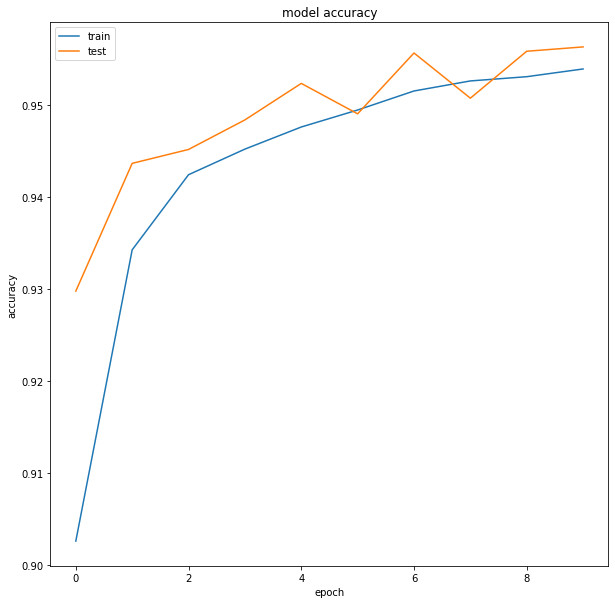

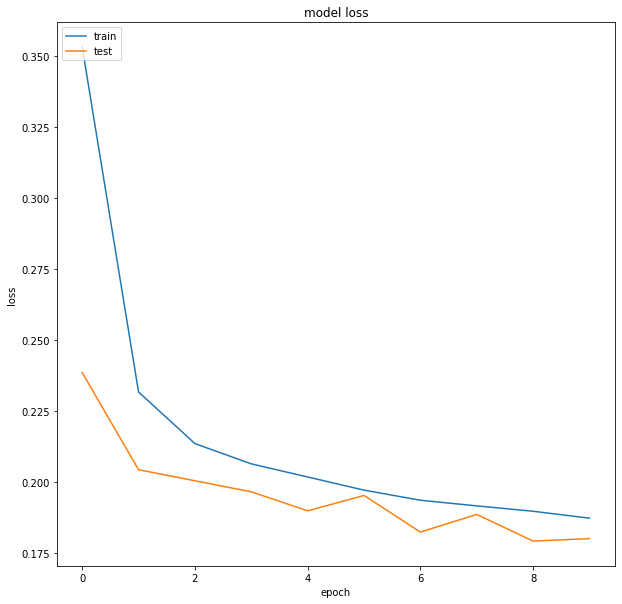

In [9]:

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
model_path = 'Model/LSTM_multi_model.h5'
bs = 100


try:
    f = open(model_path)
    # Do something with the file
    print("Trained model already exists")


except IOError:


    model = Sequential()


#     model.add(LSTM(
#              input_shape=(sequence_length, nb_features),
#              units=60,
#              return_sequences=True))
#     model.add(Dropout(0.1))

#     model.add(LSTM(
#               units=30,
#               return_sequences=False))
#     model.add(Dropout(0.1))

    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=80,
             return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(
             units=40,
             return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(
              units=20,
              return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(units=nb_out, activation='softmax'))
    adm = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['acc'])

    # adm = optimizers.Adam(learning_rate=0.0001)
    # keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    print(model.summary())


    # fit the network
    history = model.fit(seq_array, label_array_train, epochs=10, batch_size=bs, validation_split=0.1, verbose=1,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                           keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
              )

    # list all data in history
    print(history.history.keys())
    
    

    # summarize history for Accuracy
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc.savefig("Result/multi_model_accuracy.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc.savefig("Result/multi_model_loss.png")





In [10]:
'''
Evaluation
'''
# Define the function for plotting confusion matrix(cm)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    classes = classes

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print ("check4")
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.rcParams['figure.figsize'] = [15, 8]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='equal')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    yt_ref = np.arange(cm.shape[0], dtype=np.float64)

    print ("yt_ref", yt_ref)    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=yt_ref,
           ylim = (2.5, -0.5),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Precision and label setting for cm and plotting
np.set_printoptions(precision=2)
labels = ['cold', 'hot', 'normal' ]



In [14]:
'''
Test and Evaluation
'''
# pick the feature columns 
sequence_cols = test_x_df.columns.to_list()

# generator for the test sequences
seq_gen_test = list(gen_sequence(test_x_df, sequence_length, sequence_cols)) 
# print ("seq_gen_test",seq_gen_test)
# generate sequences and convert to numpy array
seq_array_test = np.asarray(seq_gen_test, dtype=np.float32 )
# shape: ( # of instances, sequence_length , # data sources(features)  )
print (seq_array_test.shape)
print ("seq_array_test[0] \n", seq_array_test[0].shape)



# generate labels
label_gen_multi_test = gen_labels(test_truth_df, sequence_length, 
                              ['label_str']) 
label_array_test = np.asarray(label_gen_multi_test)

print (label_array_test.shape)
print (label_array_test)





# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

    

# # test metrics
# scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
# print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix



y_pred_test = estimator.predict_classes(seq_array_test,verbose=1)
y_true_test = label_array_test
pd.set_option('display.max_rows', 5000)
test_print = pd.DataFrame()
# test_print['date'] = test_truth_df['date']
test_print['y_pred']  = y_pred_test.flatten()
test_print['y_truth'] = y_true_test.flatten()
print (test_print.head(5000))



# test_set = pd.DataFrame(y_pred_test)
# test_set.to_csv('Result/multi_submit_test.csv', index = None)

# print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# cm = confusion_matrix(y_true_test, y_pred_test)
# print(cm)



# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_true_test, y_pred_test, classes=labels,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true_test, y_pred_test, classes=labels, normalize=True,
#                       title='Normalized confusion matrix')





# precision, recall, fscore, support = score(y_true_test, y_pred_test)

# print('precision: {}'.format(precision))
# print('recall: {}'.format(recall))
# print('fscore: {}'.format(fscore))
# print('support: {}'.format(support))


# # compute precision and recall
# # precision_test = precision_score(y_true_test, y_pred_test)
# # recall_test = recall_score(y_true_test, y_pred_test)
# # f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
# # print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# # Plot in blue color the predicted data and in green color the
# # actual data to verify visually the accuracy of the model.
# fig_verify = plt.figure(figsize=(10, 5))
# plt.plot(y_pred_test, color="blue")
# plt.plot(y_true_test, color="green")
# plt.title('prediction')
# plt.ylabel('state')
# plt.xlabel('row')
# plt.legend(['predicted', 'actual data'], loc='upper left')
# plt.show()
# fig_verify.savefig("Result/multi_model_verify.png")





(7784, 30, 22)
seq_array_test[0] 
 (30, 22)
(7784, 1)
[['none']
 ['none']
 ['none']
 ...
 ['none']
 ['none']
 ['none']]
7784/7784 [==============================] - 11s 1ms/step
      y_pred         y_truth
0          2            none
1          2            none
2          2            none
3          2            none
4          2            none
5          2            none
6          2            none
7          2            none
8          2            none
9          2            none
10         2   abnormal(hot)
11         2   abnormal(hot)
12         1   abnormal(hot)
13         1   abnormal(hot)
14         1   abnormal(hot)
15         1   abnormal(hot)
16         1            none
17         2            none
18         2            none
19         2            none
20         2            none
21         2            none
22         2            none
23         2            none
24         2            none
25         2            none
26         2            none
27        

In [ ]:
pd.set_option('display.max_rows', 1000)
test_print = pd.DataFrame()

print (len(y_true_test))
print (len(y_pred_test))

print (y_true_test)
print (type(y_pred_test))
print (y_pred_test.shape)
print (y_true_test.flatten())
print (y_true_test.flatten().shape)

test_print['date'] = test_truth_df['date'].to_numpy()[60:,]
print (test_print)
# test_print['y_pred']  = y_pred_test.flatten()
test_print['y_pred']  = y_pred_test
test_print['y_truth'] = y_true_test.flatten()
pd.set_option('display.max_rows', 3000)
print (test_print.head(3000))

In [20]:
### Evaluation

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis=1)
    cm_col_sums = cm.sum(axis=0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis=1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0, 0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist
    mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist
    mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])

    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist ** 2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df


evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i + 1))
    evaluation_result = Evaluate(actual=test_result['label'],
                                 predicted=test_result['predicted_state'],
                                 labels=['none', 'abnormal(cold)', 'abnormal(hot)'])
    evaluation_results.append(evaluation_result)
print (evaluation_results[0])  # show full results for first split only

IndexError: list index out of range

NameError: name 'test_result' is not defined

<Figure size 864x432 with 0 Axes>

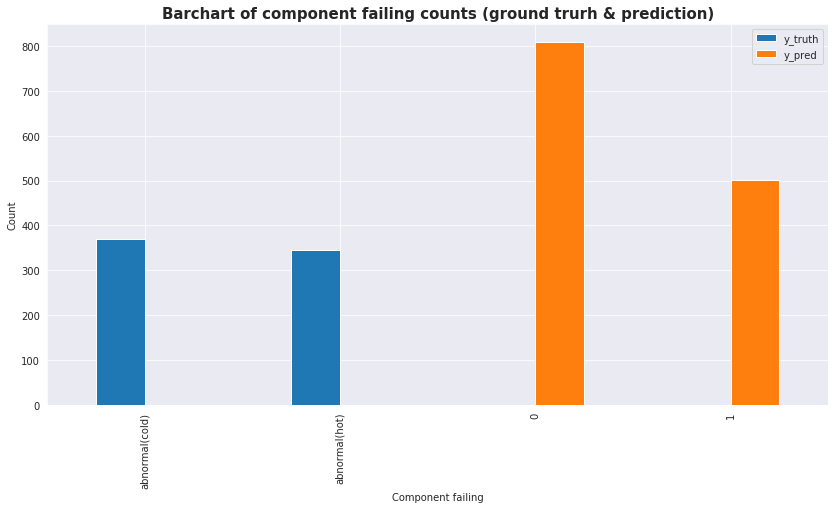

<Figure size 1008x504 with 0 Axes>

In [19]:

## Draw the barchart of component failing(ground trurh & prediction)
plt.figure(figsize=(12, 6))
counts_failures = test_print['y_truth'].value_counts().drop('none')
counts_pd_failures = test_print['y_pred'].value_counts().drop(2)
counts = pd.concat([counts_failures,counts_pd_failures],axis=1)
# print ("counts", counts )
sns.set_style("darkgrid")
ax = counts.plot(kind='bar', legend='true')
fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (ground trurh & prediction)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('Result/lstm_barchart_truth.png', bbox_inches='tight')


## Draw the barchart of component failing(ground trurh)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
test_result['label'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (without normal operation)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('Result/lstm_barchart_truth(w none).png', bbox_inches='tight')
